In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [4]:
# データ準備
beer_parray = pd.read_csv("../data/3-7-1-beer-sales-4.csv")
beer_df = pd.DataFrame(beer_parray)

print(beer_parray.shape)
print(beer_parray.head)

(150, 3)
<bound method NDFrame.head of          sales weather  temperature
0    40.643344  cloudy         13.7
1    99.552683  cloudy         24.0
2    85.326847  cloudy         21.5
3    69.287884  cloudy         13.4
4    71.099425  cloudy         28.9
..         ...     ...          ...
145  85.472193   rainy         24.6
146  87.232787   rainy         23.4
147  46.602073   rainy         16.2
148  95.857775   rainy         19.6
149  58.556600   rainy         15.8

[150 rows x 3 columns]>


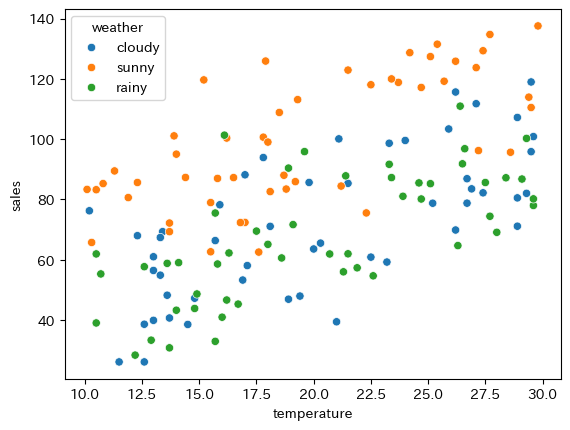

In [5]:
# データの可視化
fig, ax = plt.subplots()
ax = sns.scatterplot(x = beer_parray["temperature"], y = beer_parray["sales"],
                     hue = beer_parray["weather"])

In [6]:
# データの準備
y = beer_parray["sales"].values
X_dum_df = pd.get_dummies(beer_df.drop("sales", axis=1), dtype=int, drop_first=True)
col_li = X_dum_df.columns # 説明変数の次元指定用に取得
X = X_dum_df.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(150,)
[ 40.64334437  99.55268349  85.32684663  69.28788393  71.09942489
 107.18976885  26.06352645  78.74941786  47.91595823  39.38120332]
(150, 3)
[[13.7  0.   0. ]
 [24.   0.   0. ]
 [21.5  0.   0. ]
 [13.4  0.   0. ]
 [28.9  0.   0. ]
 [28.9  0.   0. ]
 [12.6  0.   0. ]
 [26.7  0.   0. ]
 [19.4  0.   0. ]
 [21.   0.   0. ]]
Index(['temperature', 'weather_rainy', 'weather_sunny'], dtype='object')


## ベイズ推論

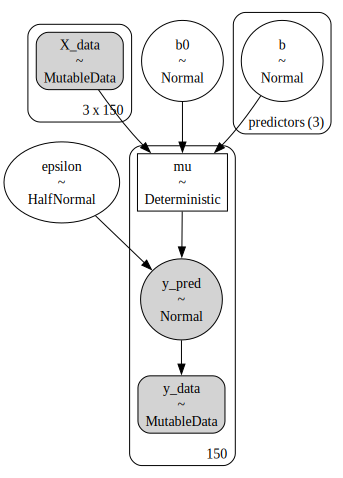

In [7]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X.T, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors")

    # 目的変数の期待値を確率変数として定義
    mu = pm.Deterministic("mu", b @ X_data + b0)

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=10000)

    # 観測値を持つ確率変数として定義
    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [8]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


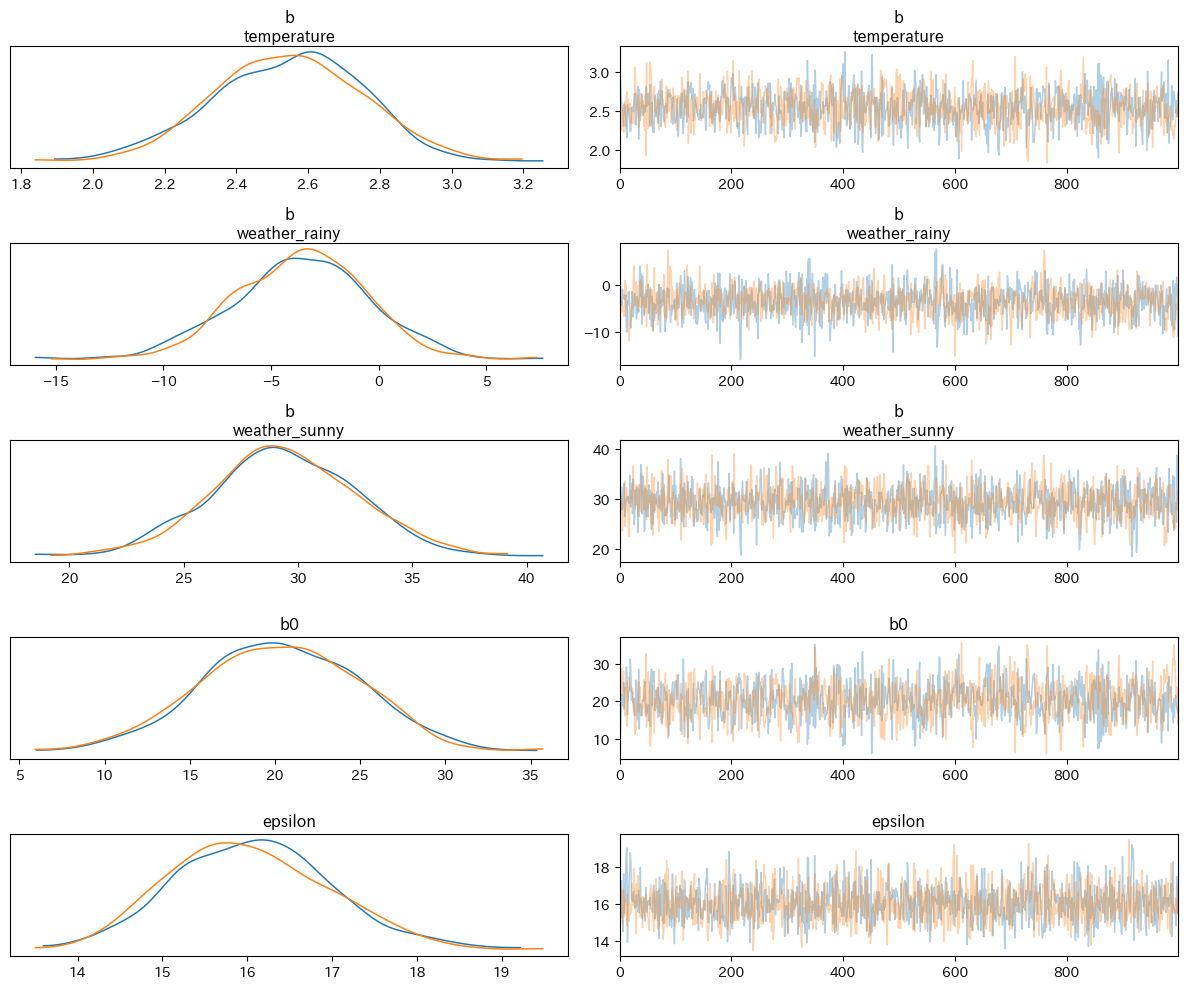

In [9]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0", "epsilon"])
plt.tight_layout();

In [10]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[temperature],2.544,0.213,2.125,2.923,0.006,0.005,1097.0,1219.0,1.0
b[weather_rainy],-3.618,3.118,-9.671,1.942,0.083,0.065,1408.0,1166.0,1.0
b[weather_sunny],29.375,3.203,23.409,35.369,0.083,0.059,1488.0,1360.0,1.0
b0,20.332,4.856,10.813,28.980,0.151,0.107,1030.0,1108.0,1.0
epsilon,16.057,0.950,14.264,17.816,0.023,0.017,1707.0,1291.0,1.0


## 回帰直線の描画(売上の期待値の分布)

In [11]:
# 入力データとして2点作成
t_min = X_dum_df["temperature"].min()
t_max = X_dum_df["temperature"].max()

# 各天気における2点データを作成
x_rainy_array = np.array([[t_min, t_max], [1, 1], [0, 0]])
x_sunny_array = np.array([[t_min, t_max], [0, 0], [1, 1]])
x_cloudy_array = np.array([[t_min, t_max], [0, 0], [0, 0]])
t_value = np.array([t_min, t_max])

print(x_rainy_array, x_rainy_array.shape)
print(x_sunny_array, x_sunny_array.shape)
print(x_cloudy_array, x_cloudy_array.shape)
print(t_value, t_value.shape)

[[10.1 29.8]
 [ 1.   1. ]
 [ 0.   0. ]] (3, 2)
[[10.1 29.8]
 [ 0.   0. ]
 [ 1.   1. ]] (3, 2)
[[10.1 29.8]
 [ 0.   0. ]
 [ 0.   0. ]] (3, 2)
[10.1 29.8] (2,)


In [12]:
# サンプリング結果からパラメータ抽出
b_ifr = idata1["posterior"]["b"].values.reshape(-1, 3)
b0_ifr = idata1["posterior"]["b0"].values.reshape(-1, 1)
print(b_ifr.shape, b0_ifr.shape)

# 各パラメータの組み合わせで、yの期待値を計算
y_rainny_preds = b_ifr @ x_rainy_array + b0_ifr # 雨のとき
y_sunny_preds = b_ifr @ x_sunny_array + b0_ifr # 晴れのとき
y_cloudy_preds = b_ifr @ x_cloudy_array + b0_ifr # 曇りのとき

print(y_rainny_preds, y_rainny_preds.shape)

(2000, 3) (2000, 1)
[[42.47680184 93.45185451]
 [40.6228376  98.86909578]
 [39.78470706 94.68354778]
 ...
 [41.72072152 90.1964157 ]
 [43.53440382 92.31533318]
 [40.06578663 91.1121108 ]] (2000, 2)


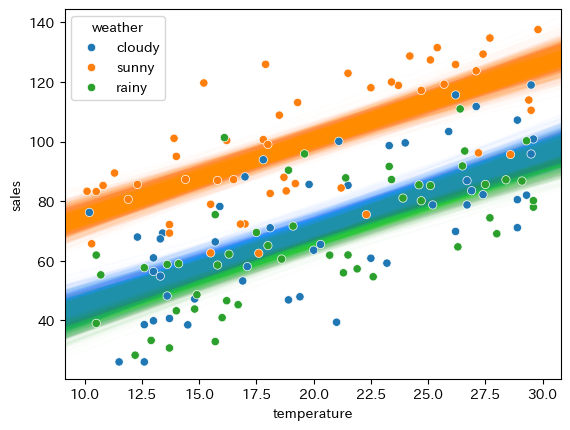

In [13]:
# データの可視化
fig, ax = plt.subplots()

# 雨の回帰直線
for y_pred in y_rainny_preds:
    ax1 = ax.axline((t_value[0], y_pred[0]), (t_value[1], y_pred[1]), alpha=0.01, c="limegreen", zorder=1)

# 晴れの回帰直線
for y_pred in y_sunny_preds:
    ax1 = ax.axline((t_value[0], y_pred[0]), (t_value[1], y_pred[1]), alpha=0.01, c="darkorange", zorder=1)

# 曇りの回帰直線
for y_pred in y_cloudy_preds:
    ax1 = ax.axline((t_value[0], y_pred[0]), (t_value[1], y_pred[1]), alpha=0.01, c="dodgerblue", zorder=1)

# 観測データの散布図
ax2 = sns.scatterplot(x = beer_parray["temperature"], y = beer_parray["sales"],
                     hue = beer_parray["weather"], zorder=2)

# ax.set(xlabel ='x-axis', ylabel='y-axis', xlim=(10, 30), ylim=(0, 150))